In [1]:
console.log("hello world")

hello world


In [23]:
function add(a: number, b: number): number {
  return a + b;
}

let result: number = add(5, 3);
console.log(result); // 8と出力されます

8


In [3]:
// 1. Variables with types
let name: string = "Tom";
let age: number = 16;
let isStudent: boolean = true;

// 2. Array and loop
let scores: number[] = [95, 88, 76];
console.log("Scores:");
for (const score of scores) {
  console.log(score);
}

// 3. Function with typed parameters and return
function greet(person: string, age: number): string {
  return `Hello, ${person}! You are ${age} years old.`;
}

// 4. Object with typed properties
interface Student {
  name: string;
  age: number;
  scores: number[];
}

let student: Student = { name, age, scores };

// 5. Display results
console.log(greet(student.name, student.age));
console.log("Average score:", student.scores.reduce((a, b) => a + b, 0) / student.scores.length);

Scores:
95
88
76
Hello, Tom! You are 16 years old.
Average score: 86.33333333333333


In [6]:
await Deno.jupyter.display({
  "text/plain": "Hello, world!",
  "text/html": "<h1>Hello, world!</h1>",
  "text/markdown": "# Hello, world!",
}, { raw: true });

Hello, world!

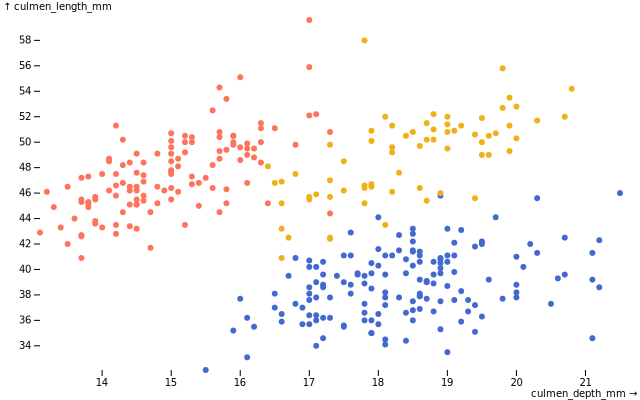

In [4]:
import { document, penguins } from "jsr:@ry/jupyter-helper";
import * as Plot from "npm:@observablehq/plot";

let p = await penguins();

Plot.plot({
  marks: [
    Plot.dot(p.toRecords(), {
      x: "culmen_depth_mm",
      y: "culmen_length_mm",
      fill: "species",
    }),
  ],
  document,
});

In [5]:
import * as csv from "jsr:@std/csv";

let baseUrl = new URL(
  "https://github.com/NationalGalleryOfArt/opendata/raw/refs/heads/main/data/",
);
let response = await fetch(new URL("objects.csv", baseUrl));

let objects = await Array.fromAsync(
  response.body.pipeThrough(new TextDecoderStream()).pipeThrough(
    new csv.CsvParseStream({ skipFirstRow: true }),
  ),
  (row) => ({
    objectid: +row.objectid,
    title: row.title,
    year: +row.beginyear,
    medium: row.medium,
    type: row.visualbrowserclassification,
  }),
);

objects.slice(0, 3);

[
  {
    objectid: 0,
    title: "Saint James Major",
    year: 1310,
    medium: "tempera on panel",
    type: "painting"
  },
  {
    objectid: 1,
    title: "Saint Paul and a Group of Worshippers",
    year: 1333,
    medium: "tempera on panel",
    type: "painting"
  },
  {
    objectid: 4,
    title: "Saint Bernard and Saint Catherine of Alexandria with the Virgin of the Annunciation [right panel]",
    year: 1387,
    medium: "tempera on poplar panel",
    type: "painting"
  }
]

In [6]:
import * as pl from "npm:nodejs-polars";

let response = await fetch(new URL("objects.csv", baseUrl));

let objects: pl.DataFrame = pl.readCSV(await response.text(), {
  quoteChar: '"',
});

objects = objects.select(
  pl.col("objectid"),
  pl.col("title"),
  pl.col("beginyear").as("year"),
  pl.col("medium"),
  pl.col("visualbrowserclassification").as("type"),
);

objects.head()

objectid,title,year,medium,type
0,Saint James Major,1310,tempera on panel,painting
1,Saint Paul and a Group of Worshippers,1333,tempera on panel,painting
4,Saint Bernard and Saint Catherine of Alexandria with the Virgin of the Annunciation [right panel],1387,tempera on poplar panel,painting
17,Matteo Olivieri (?),1430,tempera (and oil?) on panel transferred to canvas,painting
19,Portrait of a Man,1450,tempera on panel,painting


In [7]:
let response = await fetch(new URL("constituents.csv", baseUrl));
let constituents = pl.readCSV(await response.text(), { quoteChar: '"' })
  .select(
    pl.col("constituentid"),
    pl.col("forwarddisplayname").alias("name"),
    pl.col("visualbrowsernationality").alias("nationality"),
  );

constituents.head();

constituentid,name,nationality
9,Anonymous,Other
11,Hans Baldung,Other
12,National Gallery of Art,Other
13,Anonymous Artist,Other
14,Mrs. Thomas M. Evans,American


In [8]:
let response = await fetch(new URL("published_images.csv", baseUrl));
let publishedImages = pl.readCSV(await response.text(), { quoteChar: '"' })
  .select(
    pl.col("depictstmsobjectid").alias("objectid"),
    pl.col("uuid"),
    pl.col("iiifthumburl").alias("thumburl"),
  );
publishedImages.head();

objectid,uuid,thumburl
17387,00007f61-4922-417b-8f27-893ea328206c,"https://api.nga.gov/iiif/00007f61-4922-417b-8f27-893ea328206c/full/!200,200/0/default.jpg"
19245,0000bd8c-39de-4453-b55d-5e28a9beed38,"https://api.nga.gov/iiif/0000bd8c-39de-4453-b55d-5e28a9beed38/full/!200,200/0/default.jpg"
23830,0001668a-dd1c-48e8-9267-b6d1697d43c8,"https://api.nga.gov/iiif/0001668a-dd1c-48e8-9267-b6d1697d43c8/full/!200,200/0/default.jpg"
713,00032658-8a7a-44e3-8bb8-df8c172f521d,"https://api.nga.gov/iiif/00032658-8a7a-44e3-8bb8-df8c172f521d/full/!200,200/0/default.jpg"
71457,0003d4e4-d7fd-4835-8d27-1e9e20672e39,"https://api.nga.gov/iiif/0003d4e4-d7fd-4835-8d27-1e9e20672e39/full/!200,200/0/default.jpg"


In [9]:
let response = await fetch(new URL("objects_constituents.csv", baseUrl));
let objectToArtist = pl.readCSV(await response.text(), { quoteChar: '"' })
  .filter(pl.col("role").eq(pl.lit("artist")))
  .sort({ by: "displayorder" })
  .groupBy("objectid")
  .first()
  .select("objectid", "constituentid");

objectToArtist.head();

objectid,constituentid
62145,5923
34876,3778
72488,4711
52448,13
226786,53188


In [14]:
let publicDomainIds = Deno.readTextFileSync("data/public-domain-ids.txt")
  .split("\n").map((d) => +d);

In [15]:
let df = objects
  .join(objectToArtist, { on: "objectid" })
  .join(constituents, { on: "constituentid" })
  .join(publishedImages, { on: "objectid" })
  .select(pl.exclude("constituentid"))
  .withColumns(pl.col("objectid").isIn(publicDomainIds).alias("public"))
  .sort({ by: "public" })
  .sort({ by: "year", descending: true, nullsLast: true });

df.head();

objectid,title,year,medium,type,name,nationality,uuid,thumburl,public
147850,N. Y. Street,null,lithograph,print,Unknown,Other,799aa8f8-78b8-4f70-8512-8692c7012b7d,"https://api.nga.gov/iiif/799aa8f8-78b8-4f70-8512-8692c7012b7d/full/!200,200/0/default.jpg",false
184698,Les Deux Bourrines,null,etching,print,Auguste Lepère,French,b8747a8b-daba-4f5e-a187-06438912ee97,"https://api.nga.gov/iiif/b8747a8b-daba-4f5e-a187-06438912ee97/full/!200,200/0/default.jpg",false
38910,Ex Libris Th. Vandenheede,null,engraving,print,Brochery,Other,84724f22-0fb5-48e9-835f-2f52ade9f9d8,"https://api.nga.gov/iiif/84724f22-0fb5-48e9-835f-2f52ade9f9d8/full/!200,200/0/default.jpg",false
144203,City Lights,null,lithograph,print,Robert Stockton,American,37a15f5a-b52f-4d80-93e4-d09f0095af9a,"https://api.nga.gov/iiif/37a15f5a-b52f-4d80-93e4-d09f0095af9a/full/!200,200/0/default.jpg",false
145709,Untitled (Bar Room),null,screenprint,print,Unknown,Other,ae69eaa2-3994-41bc-a428-13f91e3ddf8e,"https://api.nga.gov/iiif/ae69eaa2-3994-41bc-a428-13f91e3ddf8e/full/!200,200/0/default.jpg",false


In [16]:
import * as Plot from "npm:@observablehq/plot";
import { document } from "jsr:@manzt/jupyter-helper";

// Convert our DataFrame to Array<Object>
let records = df.toRecords();

Plot.plot({
  width: 900,
  marginLeft: 50,
  color: { legend: true },
  marks: [
    Plot.barY(
      records,
      Plot.groupX({ y: "count" }, {
        x: "type",
        sort: { x: "-y" },
        fill: (d) => d.public ? "Public domain" : "Copyrighted",
      }),
    ),
  ],
  // Provide a custom `document`
  document,
});

Copyrighted Public domain 0 5,000 10,000 15,000 20,000 25,000 30,000 35,000 40,000 45,000 ↑ Frequency print drawing photograph portfolio sculpture volume painting decorative art technical material new media type

In [17]:
Plot.plot({
  width: 900,
  marginLeft: 50,
  color: { legend: true },
  marks: [
    Plot.waffleY(
      /* changed, Plot.barY */
      records,
      Plot.groupZ(
        /* changed, Plot.groupX */
        { y: "count" },
        {
          fx: "type",
          fill: (d) => d.public ? "Public Domain" : "Copyrighted",
          sort: { fx: "-y" }, /* changed, sort: { x: "-y"  } */
          unit: 300, /* new */
        },
      ),
    ),
    Plot.ruleY([0]),
  ],
  document,
});

Copyrighted Public Domain print drawing photograph portfolio sculpture volume painting decorative art technical material new media type 0 5,000 10,000 15,000 20,000 25,000 30,000 35,000 40,000 45,000 ↑ Frequency

In [18]:
const artworkTotals = df
  .groupBy("name", "public")
  .len()
  .sort("name_count", true)
  .head(25)
  .toRecords();

Plot.plot({
  marginLeft: 200,
  color: { legend: true },
  marks: [
    Plot.barX(artworkTotals, {
      x: "name_count",
      y: "name",
      sort: { y: "-x" },
      fill: (d) => d.public ? "Public domain" : "Copyrighted",
    }),
  ],
  document,
});

Copyrighted Public domain Robert Frank Honoré Daumier Alfred Stieglitz Jasper Johns Richard Diebenkorn American 20th Century Jacques Callot Max Beckmann Mark Rothko Charles B. J. Févret de Saint-Mémin Alphonse Legros James McNeill Whistler Lee Friedlander David Young Cameron American 19th Century Unknown 19th Century Eadweard Muybridge John Marin German 15th Century Robert Havell, Jr. M.C. Escher Allen Ginsberg Albrecht Dürer Ernst Ludwig Kirchner name 0 1,000 2,000 3,000 4,000 5,000 name_count →

In [19]:
import { agGrid } from "jsr:@manzt/jupyter-helper";

agGrid(df.head(200)); // just look at the first 200 items

In [20]:
import { quak } from "jsr:@manzt/jupyter-helper";

const paintings = df.filter(pl.col("type").eq(pl.lit("painting")));
quak(paintings);

In [21]:
import * as React from "npm:react";
import { render } from "jsr:@manzt/jupyter-helper";

function Gallery({ objects, size = 100 }) {
  return (
    <div
      style={{
        display: "grid",
        gridTemplateColumns: `repeat(auto-fill, minmax(${size}px, 1fr))`,
        gap: "4px",
      }}
    >
      {objects.select("objectid", "thumburl", "title", "public")
        .map(([objectid, thumburl, title, publicDomain]) => (
          <div
            key={objectid}
            style={{ position: "relative", textAlign: "center" }}
          >
            <a
              href={`https://www.nga.gov/collection/art-object-page.${objectid}.html`}
              style={{
                display: "block",
                width: `${size}px`,
                height: `${size}px`,
                position: "relative",
              }}
            >
              <img
                src={thumburl}
                alt={title}
                style={{
                  width: "100%",
                  height: "100%",
                  objectFit: "cover",
                  borderRadius: "5px",
                }}
              />{" "}
              {publicDomain && (
                <img
                  src="https://mirrors.creativecommons.org/presskit/icons/zero.svg"
                  alt="Public Domain"
                  style={{
                    position: "absolute",
                    bottom: "3px",
                    right: "3px",
                    width: "20px",
                    height: "20px",
                    opacity: 0.60,
                  }}
                />
              )}
            </a>
          </div>
        ))}
    </div>
  );
}

In [22]:
render(<Gallery objects={df.sample(20)} />);